# SoftVQ-VAE: Efficient 1D Continuous Tokenizer

In [1]:
import torch
from PIL import Image
import numpy as np
import requests
import sys 
sys.path.append('../')
from modelling.tokenizer import SoftVQModel
from modelling.samplers import euler_sampler, euler_maruyama_sampler
from modelling.sit import SiT
from matplotlib import pyplot as plt
from torchvision.utils import save_image
from PIL import Image
from IPython.display import display

/storage/haoc/miniconda3/envs/softvq/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/storage/haoc/continuous_tokenizer/demo/../modelling/modules/timm_vit/vision_transformer.py:2200: UserWarning: Overwriting vit_tiny_patch16_224 in registry with modelling.modules.timm_vit.vision_transformer.vit_tiny_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def vit_tiny_patch16_224(pretrained: bool = False, **kwargs) -> VisionTransformer:
/storage/haoc/continuous_tokenizer/demo/../modelling/modules/timm_vit/vision_transformer.py:2209: UserWarning: Overwriting vit_tiny_patch16_384 in registry with modelling.modules.timm_vit.vision_transformer.vit_tiny_patch16_384. This is because the name being registered conflicts with an existing name

## Load Tokenizer and SiT Model

In [2]:
# available models
# softvq-l-64, softvq-l-32, softvq-bl-64, softvq-bl-32, softvq-b-64, softvq-b-32
vae_name = 'softvq-l-64'
vae = SoftVQModel.from_pretrained(f"SoftVQVAE/{vae_name}")
vae = vae.eval()
sit = SiT.from_pretrained(f"SoftVQVAE/sit-xl_{vae_name}")
sit = sit.eval()

In [8]:
if torch.cuda.is_available():
    vae = vae.cuda()
    sit = sit.cuda()
    device = torch.device('cuda')
    device_type = 'cuda'
else:
    device = torch.device('cpu')
    device_type = 'cpu'

## Generate 

/tmp/ipykernel_2882465/216628089.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad() and torch.cuda.amp.autocast():


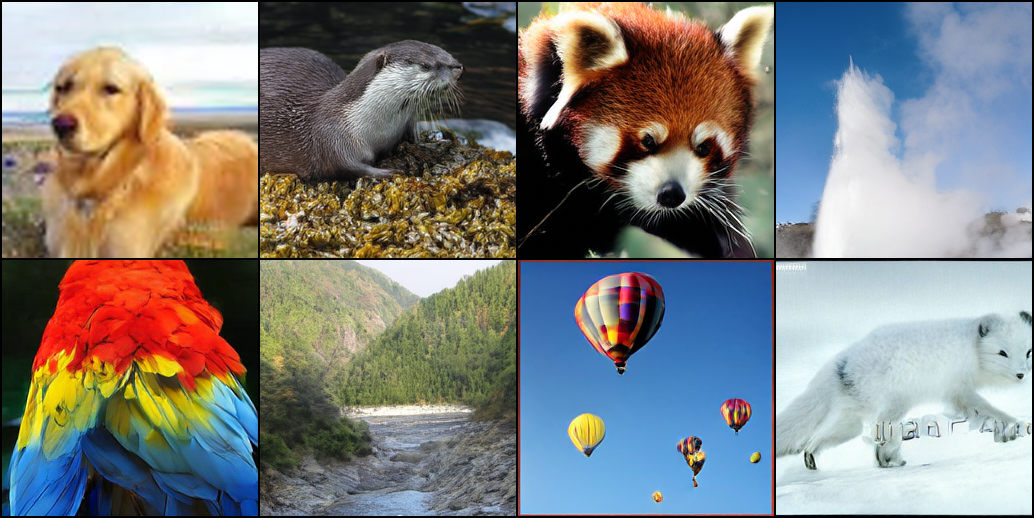

In [9]:
# Set user inputs:
seed = 42 #@param {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 250 #@param {type:"slider", min:0, max:1000, step:1}
cfg_scale = 4.0 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = 207, 360, 387, 974, 88, 979, 417, 279 #@param {type:"raw"}
samples_per_row = 4 #@param {type:"number"}
mode = "ode" #@param ["ODE", "SDE"]
path_type = 'cosine'
guidance_low = 0.0 #@param {type:"slider", min:0.0, max:0.5, step:0.05}
guidance_high = 1.0 #@param {type:"slider", min:0.5, max:1.0, step:0.05}
using_cfg = cfg_scale > 1.0

# Create sampling noise:
n = len(class_labels)
z = torch.randn(n, vae.num_latent_tokens, vae.codebook_embed_dim, device=device)
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)

# Sample images:
sampling_kwargs = dict(
    model=sit, 
    latents=z,
    y=y,
    num_steps=num_sampling_steps, 
    cfg_scale=cfg_scale,
    guidance_low=guidance_low,
    guidance_high=guidance_high,
    path_type=path_type,
)
with torch.no_grad() and torch.cuda.amp.autocast():
    if mode == "sde":
        samples = euler_maruyama_sampler(**sampling_kwargs).to(torch.float32)
    elif mode == "ode":
        samples = euler_sampler(**sampling_kwargs).to(torch.float32)
    else:
        raise NotImplementedError()
    
    if using_cfg:
        samples, _ = samples.chunk(2, dim=0)  # Remove null class samples

    samples = vae.decode(samples * vae.vq_std + vae.vq_mean)
    
samples = torch.clamp(samples, -1.0, 1.0)
samples = (samples + 1) / 2

# Save and display images:
save_image(samples, "sample.png", nrow=int(samples_per_row), 
           normalize=True, value_range=(0.0, 1.0))
samples = Image.open("sample.png")
display(samples)